In [2]:
# Imports
import time
import copy
import itertools
from itertools import combinations
import os
import io
import shutil
from tempfile import NamedTemporaryFile
import warnings
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from scipy.optimize import minimize, basinhopping, differential_evolution, OptimizeResult
from scipy.integrate import solve_ivp
from scipy.stats import norm, uniform, qmc, spearmanr
from joblib import Parallel, delayed
from collections import deque
import re
from julia import Julia
import sqlite3
julia = Julia(sysimage="sysimage.so")  # Initialize a new Julia instance
from julia import Main
Main.eval('using DifferentialEquations')
import contextlib


In [3]:
#ASA Optimizer

def vfsa_accprob(curr_cost, new_cost, temp_acc):
    exponent = np.clip((new_cost - curr_cost) / temp_acc, -500, 500)
    return 1 / (1 + np.exp(exponent))

def vfsa_gen_step(dim, log_lb, log_ub, temp_gen, rng=None):
    if rng is None: # New seed for each instance/thread
        rng = np.random.default_rng()
    
    uni = rng.random(dim)
    base = 1 + 1 / (temp_gen + 1e-10)  # add small value in case of zero temp
    exponent = 2 * uni - 1
    rnd = np.sign(uni - 0.5) * temp_gen * (base**exponent - 1)
    return (log_ub - log_lb) * rnd

def vfsa_gen_params(curr_params, dim, log_lb, log_ub, temp_gen):
    log_params = np.log10(curr_params)
    
    # Calculate the maximum allowable step sizes within the bounds
    max_steps_up = log_ub - log_params
    max_steps_down = log_params - log_lb
    log_step = vfsa_gen_step(dim, -1, 1, temp_gen)
    scaled_step = np.minimum(max_steps_up, np.maximum(-max_steps_down, log_step))
    new_log_params = log_params + scaled_step
    
    return 10 ** new_log_params
        
def vfsa_generinitpoint(dim, log_lb, log_ub, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    uni = rng.random(dim)
    log_initpoints = log_lb + (log_ub - log_lb) * uni
    return 10 ** log_initpoints

def vfsa_reannealing(best_cost, best_params, curr_cost, dim, x0, tmax, tscat, data, c, temp_gen, temp0_gen, objective_function):
    log_orig_best_params = np.log10(best_params)
    log_par_delta = log_orig_best_params + 0.01 * log_orig_best_params
    par_delta = 10 ** log_par_delta
    
    cost_delta = np.array([
        objective_function(par_delta if i == j else best_params)
        for j in range(dim)
    ])
    
    par_diff = np.clip(par_delta - best_params, 1e-10, None)  # Avoid division by zero
    s = np.abs((cost_delta - best_cost) / par_diff) * (best_params / best_cost)
    smax = np.max(s)
    
    # Ensure no division by zero or negative values
    temp_gen = np.clip(temp_gen * (smax / np.clip(s, 1e-10, None)), 1e-10, None)
    
    k_gen = (-1/c * np.log(np.clip(temp_gen / temp0_gen, 1e-10, None))) ** dim
    k_gen = np.clip(k_gen, 0, None)  # Ensure non-negative values
    
    temp0_acc = curr_cost
    temp_acc = best_cost
    k_acc = (-1/c * np.log(np.clip(temp_acc / temp0_acc, 1e-10, None))) ** dim
    
    return temp_gen, k_gen, temp0_acc, temp_acc, k_acc

def vfsa_temp(temp_gen0, c, k_gen, dim, min_temp=1e-10):
    exponent = -c * np.power(k_gen, 1/dim)
    temp = temp_gen0 * np.exp(exponent)
    return np.clip(temp, min_temp, None)

def simulated_annealing(objective_function, initial_solution, lower_bounds, upper_bounds, 
                        initial_temperature, cooling_rate, max_iterations, neighborhood_function, 
                        log_lb, log_ub, temp_gen, 
                        M=10, eps=0.0, min_temp=1e-10, verbose=False):
    
    current_solution = initial_solution
    current_cost = objective_function(current_solution)
    best_solution = current_solution
    best_cost = current_cost
    temperature = initial_temperature

    reanneal_cost_vec = [best_cost]
    diff = deque(maxlen=M)
    best_diff = deque(maxlen=M)
    count_acc_points = 0

    for iteration in range(max_iterations):
        # Generate a new solution in the neighborhood
        new_solution = neighborhood_function(current_solution, len(current_solution), log_lb, log_ub, temp_gen)
        new_cost = objective_function(new_solution)
        delta_cost = new_cost - current_cost
        
        # Acceptance probability
        if delta_cost < 0 or np.random.rand() < np.exp(-delta_cost / temperature):
            current_solution = new_solution
            current_cost = new_cost
            count_acc_points += 1
            
            # Update the best solution found
            if current_cost < best_cost:
                best_solution = current_solution
                best_cost = current_cost

            # Reannealing: Store the best cost at this point
            reanneal_cost_vec.append(best_cost)
            if len(reanneal_cost_vec) > 1:
                diff.append(abs(reanneal_cost_vec[-1] - reanneal_cost_vec[-2]))
                best_diff.append(abs(reanneal_cost_vec[-1] - best_cost))

                # Termination condition based on the last M accepted costs
                if len(diff) == M and all(d <= eps for d in diff) and all(bd <= eps for bd in best_diff):
                    print('ASA converged, terminating at', iteration)
                    break
        
        # Decrease the temperature with a check for minimum temperature
        temperature = max(min_temp, temperature * cooling_rate)
        
        # Progress print statements
        if iteration % (max_iterations // 10) == 0:
            print(f"Iteration {iteration}: Current cost = {current_cost}, Best cost = {best_cost}", flush=verbose)
            print(f"Current solution: {current_solution}", flush=verbose)
        
    return best_solution, best_cost

def ASA(objective_function, x0, bounds, maxiter=100, initial_temp=1.0, cooling_rate=0.95, 
        neighborhood_function=vfsa_gen_params, init_function=vfsa_generinitpoint, 
        **kwargs):
    
    dim = len(x0)
    lower_bounds, upper_bounds = np.array(bounds).T
    log_lb, log_ub = np.log10(lower_bounds), np.log10(upper_bounds)
    log_bounds = list(zip(log_lb, log_ub))
    initial_solution = init_function(dim, log_lb, log_ub)
    
    # Run ASA optimization
    best_solution, best_cost = simulated_annealing(
        objective_function, initial_solution, lower_bounds, upper_bounds,
        initial_temp, cooling_rate, maxiter, neighborhood_function,
        log_lb, log_ub, initial_temp, verbose=True,
        **kwargs
    )
    print('ASA best cost:', best_cost)
    print(best_solution)

    minimizer_kwargs = {
        'method': 'L-BFGS-B',
        'options': {
            'disp': True,
            'maxiter': 250,
        }
    }

    local_result = minimize(
        objective_function,
        x0=best_solution,
        bounds=bounds,
        **minimizer_kwargs
    )
    
    final_solution = local_result.x
    final_cost = local_result.fun
    nfev = local_result.nfev
    success = local_result.success

    return OptimizeResult(x=final_solution, fun=final_cost, nfev=nfev, success=success)

In [22]:
# Infrastructure functions
def calculate_mean_patient_data(patients, data_key):
    all_data = []
    for patient in patients.values():
        df = patient.df[['DAY', data_key]].copy()
        df.loc[df[data_key] < 1, data_key] = 1
        all_data.append(df)

    combined_data = pd.concat(all_data)
    mean_data = combined_data.groupby('DAY')[data_key].apply(lambda x: np.log10(x).mean()).reset_index()
    std_data = combined_data.groupby('DAY')[data_key].apply(lambda x: np.log10(x).std()).reset_index()

    return mean_data, std_data

def calculate_mean_twin_data(twin_data, data_key):
    twin_data = twin_data[['DAY', data_key]].copy()
    twin_data.loc[twin_data[data_key] < 1, data_key] = 1

    mean_data = twin_data.groupby('DAY')[data_key].apply(lambda x: np.log10(x).mean()).reset_index()
    std_data = twin_data.groupby('DAY')[data_key].apply(lambda x: np.log10(x).std()).reset_index()

    return mean_data, std_data

class TimeManager:
    def __init__(self):
        self.start_time = time.time()

    def check_timeout(self, timeout: int) -> bool:
        return (time.time() - self.start_time) > timeout

    def reset_start_time(self):
        self.start_time = time.time()

    def get_elapsed_time(self) -> float:
        return time.time() - self.start_time

def unique_colors(ids):
    num_colors = len(ids)
    colors = sns.color_palette("husl", num_colors)
    return dict(zip(ids, colors))

class Parameter:
    def __init__(self, name, val=None, l_lim=None, u_lim=None, dist='uniform', method='fixed', space='log10', dtype=np.float32):
        self.name = name
        self.dtype = dtype
        self.space = space
        self.l_lim = self._transform_bound(l_lim)
        self.u_lim = self._transform_bound(u_lim)
        self.dist = self._create_distribution(dist, l_lim, u_lim)
        self.val = self._convert_to_type(val if val is not None else self.sample_prior())
        self.method = method

    def _transform_bound(self, bound):
        if self.space == 'log10':
            return np.log10(bound)
        elif self.space == 'normal':
            return bound
        else:
            raise ValueError(f"Unsupported space type: {self.space}")

    def _inverse_transform(self, value):
        """Inverse transform a value back to natural space."""
        if self.space == 'log10':
            return 10 ** value
        elif self.space == 'normal':
            return value
        else:
            raise ValueError(f"Unsupported space type: {self.space}")

    def _create_distribution(self, dist, l_lim, u_lim):
        """Create the sampling distribution based on transformed bounds."""
        if dist == 'uniform':
            return uniform(loc=l_lim, scale=u_lim - l_lim)
        elif dist == 'normal':
            return norm(loc=(l_lim + u_lim) / 2, scale=(u_lim - l_lim) / 6)
        else:
            raise ValueError(f"Unsupported distribution type: {dist}")

    def _convert_to_type(self, value):
        return np.array(value, dtype=self.dtype).item()

    def sample_prior(self):
        """Sample a value from the prior distribution and inverse transform it."""
        sampled_value = self.dist.rvs()
        return self._convert_to_type(self._inverse_transform(sampled_value))


    def __repr__(self):
        return f"{self.val:.2e}"

    def sweep(self, num_points=100):
        values = np.linspace(self.l_lim, self.u_lim, num=num_points)
        if self.space == 'log10':
            values = 10 ** values  # Inverse transform back to natural space
        return [self._convert_to_type(val) for val in values]

class Parameters:
    def __init__(self, **kwargs):
        self._parameters = kwargs

    def __getattr__(self, item):
        if item in self._parameters:
            return self._parameters[item]
        raise AttributeError(f"'Parameters' object has no attribute '{item}'")

    def __setattr__(self, key, value):
        if key == '_parameters':
            super().__setattr__(key, value)
        else:
            self._parameters[key] = value
            self.reset_solutions()

    def __getstate__(self):
        return self._parameters

    def __setstate__(self, state):
        self._parameters = state

    def items(self):
        return self._parameters.items()

    def __repr__(self):
        return f"Parameters({', '.join([f'{k}={v}' for k, v in self._parameters.items()])})"

    def sample_priors(self, force_sample=False):
        for name, param in self._parameters.items():
            if force_sample or param.method == 'sample':
                param.val = param.sample_prior()
        return {name: param for name, param in self._parameters.items()}

    def reset_solutions(self):
        # Reset solutions in all patients whenever a parameter value is updated
        if hasattr(self, 'patients'):
            for patient in self.patients.values():
                patient.sol = None
                patient.sse = None

    def load_parameters_from_dataframe(self, df_params, patient_id):
        if patient_id not in df_params['id'].values:
            print(f"ID {patient_id} not found in parameter file.")
            return
        param_values = df_params[df_params['id'] == patient_id].iloc[0]
        for param_name, param_obj in self._parameters.items():
            if param_obj.method == 'file' and param_name in param_values:
                param_val = param_values[param_name]
                if not np.isnan(param_val):
                    param_obj.val = param_val
                else:
                    print(f"Parameter '{param_name}' for ID {patient_id} is missing in the parameter file. Falling back to original values.")
    
    def copy(self):
        copied_params = {name: copy.deepcopy(param) for name, param in self._parameters.items()}
        return Parameters(**copied_params)

class State:
    def __init__(self, label: str, initial_value: float = 0.0, sse: bool = False, dtype: np.dtype = np.float32, force_positive: bool = True, scale: float = 1.0):
        self.label = label
        self.initial_value = dtype(initial_value)
        self.dtype = dtype
        self.force_positive = force_positive
        self.time_points = np.array([0.0], dtype=dtype)
        self.values = np.array([self.initial_value], dtype=dtype)
        self.sse = sse

    def update_value(self, t: float, new_value: float):
        new_value = np.clip(new_value, np.finfo(self.dtype).min, np.finfo(self.dtype).max)
        new_value = self.dtype(new_value)
        if self.force_positive:
            new_value = max(new_value, 0)
        self.time_points = np.append(self.time_points, self.dtype(t))
        self.values = np.append(self.values, new_value)

    def get_latest_value(self) -> float:
        return self.values[-1]

    def get_value_at(self, t_delay: float) -> float:
        value = np.interp(self.dtype(t_delay), self.time_points, self.values, left=self.initial_value, right=self.values[-1])
        if self.force_positive:
            value = max(value, 0)
        return value

    def reset(self):
        self.time_points = np.array([0.0], dtype=self.dtype)
        self.values = np.array([self.initial_value], dtype=self.dtype)

    def __repr__(self):
        return f"State(label={self.label}, initial_value={self.initial_value}, dtype={self.dtype}, force_positive={self.force_positive})"

class States:
    def __init__(self, states_config: list, dtype: np.dtype = np.float32, force_positive: bool = True):
        self.dtype = dtype
        self.force_positive = force_positive
        self.states = {config['label']: State(**config, dtype=dtype, force_positive=force_positive) for config in states_config}
        self.tau = {}
        self.state_labels = [state.label for state in self.states.values()]

    def get_delayed_state(self, state_label: str) -> float:
        return self.tau.get(state_label, 0.0)

    def get_current_values_as_array(self) -> np.ndarray:
        return np.array([self.states[label].get_latest_value() for label in self.state_labels], dtype=self.dtype)

    def __getattr__(self, name: str) -> float:
        if name in self.states:
            return self.states[name].get_latest_value()
        elif name in self.tau:
            return self.tau[name]
        else:
            raise AttributeError(f"'States' object has no attribute '{name}'")

    def update_states(self, t: float, new_values: list):
        for label, value in zip(self.state_labels, new_values):
            self.states[label].update_value(t, value)

    def calculate_delayed_states(self, t: float, delays: list, p: any):
        for delay_info in delays:
            tau, dependent_state, affecting_state = delay_info['tau'], delay_info['dependent_state'], delay_info['affecting_state']
            delay_time = getattr(p, tau).val
            delayed_value = self.states[affecting_state].get_value_at(t - delay_time)
            delayed_state_label = f"{affecting_state}_{dependent_state}"
            self.tau[delayed_state_label] = delayed_value

    def reset_delayed_states(self):
        self.tau.clear()

    def __repr__(self):
        return f"States({', '.join([f'{k}={v}' for k, v in self.states.items()])}, dtype={self.dtype}, force_positive={self.force_positive})"

class NoOpMinimizer:
    def __call__(self, x):
        return x

class Patient:
    def __init__(self, id, color, t_span, df, parameters, states, df_params=None, soly=None, solt=None, solve_time=np.nan, sse=np.inf, sse_statewise=np.inf):
        self.id = id
        self.color = color
        self.t_span = t_span
        if isinstance(id, str) and (id == 'MP' or (id.startswith('S') and id[1:].isdigit())):
            self.df = df
        else:
            self.df = df[df['VOLUNTEER'] == id].copy()
        self.parameters = parameters
        self.states = states
        self.soly = soly
        self.solt = solt
        self.solve_time = solve_time
        self.sse = sse
        self.sse_statewise = sse_statewise

        if df_params is not None:
            self.parameters.load_parameters_from_dataframe(df_params, self.id)
        self.param_names = list(self.parameters._parameters.keys())
        self.results_in_memory = []  # To store results for later DB writes

    def solve(self):
        try:
            self.solt, self.soly = JuliaSolve((
                self.parameters, self.states, self.t_span
            ))
        except Exception as e:
            self.soly = None
            self.solt = None
            print(f"Error solving patient {self.id}: {e}")
    
    def compare(self, soly=None, solt=None):
        if soly is None: soly=self.soly
        if solt is None: soly=self.solt
        sse = 0
        length = len(self.states)+1
        sse_array = [0] * length

        weight_dict = {
            103: 11.941,
            107: 13.425,
            110: 5.305,
            111: 5.401,
            112: 7.765,
            204: 2.851,
            207: 7.264,
            302: 7.518,
            307: 6.584,
            308: 6.636,
            311: 4.948,
            312: 9.312,
            'MP': 6.2,
        }

        if self.df is None or soly is None:
            print('compare abort')
            self.sse = np.inf
            self.sse_statewise = np.inf * len(self.states)
            return self.sse

        all_data_slopes = []
        all_model_slopes = []

        for idx, state in enumerate(self.states):
            state_label = state['label']
            state_sse = 0
            if state_label == 'CD8TE' or state_label == 'V':
                if state_label in self.df.columns:
                    data_values = self.df[state_label].values * state.get('scale', 1.0)
                    time_points = self.df['DAY'].values
                    valid_indices = ~np.isnan(data_values)
                    data_values = data_values[valid_indices]
                    time_points = time_points[valid_indices]
                    # Trim off repeated terminal zeros
                    # Find the index where the last non-zero value occurs
                    if len(data_values) > 0:
                        # Reverse iterate over the data to find repeated terminal zeros
                        last_non_zero_idx = len(data_values) - 1
                        for i in range(len(data_values) - 1, -1, -1):
                            if data_values[i] != 0:
                                last_non_zero_idx = i
                                break
                        
                        # Trim all zeros after the first zero after the last non-zero index
                        trimmed_data_values = data_values[:last_non_zero_idx + 1]
                        trimmed_time_points = time_points[:last_non_zero_idx + 1]
                    
                        # Reapply the valid_indices mask, ensuring the data aligns with the original length
                        data_values = trimmed_data_values
                        print('data',data_values)
                        time_points = trimmed_time_points

                    weight = 1
                    if state_label == 'V':
                        weight = (1 / weight_dict[self.id])
                    if state_label == 'CD8TE':
                        weight = 1 #weight_dict[self.id]

                    if len(data_values) > 0:
                        model_time_points = solt
                        #print('model time points:',np.shape(model_time_points))
                        model_values = soly[:,idx]
                        #print(f'{state_label} vals:',model_values)

                        if model_values.shape[0] != len(model_time_points):
                            model_values = np.transpose(model_values)

                        interpolated_model_values = np.interp(time_points, model_time_points, model_values)
                        print('model',interpolated_model_values, flush=True)
                        for i in range(len(time_points)):  # Loop through all data points
                            floor = 1.0
                            data_at_t = data_values[i]
                            model_at_t = interpolated_model_values[i]
                            logdata = np.log10(np.maximum(data_at_t, floor))
                            logmodel = np.log10(np.maximum(model_at_t, floor))
                            error = (logmodel - logdata) ** 2
                            state_sse += error
                            if state.get('sse', True): sse += error * weight

                            # Collect slopes for all points except the last (forward slope)
                            if state_label == 'CD8TE' and state.get('sse', True) and i < len(time_points) - 1:
                                logdata_ti1 = np.log10(np.maximum(data_values[i + 1], floor))
                                logmodel_ti1 = np.log10(np.maximum(interpolated_model_values[i + 1], floor))

                                slope_data = logdata_ti1 - logdata
                                slope_model = logmodel_ti1 - logmodel

                                if np.isfinite(slope_data) and np.isfinite(slope_model):
                                    all_data_slopes.append(slope_data)
                                    all_model_slopes.append(slope_model)

                    sse_array[idx] = state_sse

        # After collecting all slopes, calculate SE3 and apply slope penalties
        if len(all_data_slopes) > 0 and len(all_model_slopes) > 0:
            max_slope_data = max(all_data_slopes)
            min_slope_data = min(all_data_slopes)
            Vdat = self.df['V'].values
            Vdat = Vdat[~np.isnan(Vdat)]
            SE3 = np.log10(max(Vdat)) / (max_slope_data - min_slope_data)
            #print('Final Slope weight', SE3, flush=True)

            for model_slope, data_slope in zip(all_model_slopes, all_data_slopes):
                slope_penalty = 0.5 * SE3 * (model_slope - data_slope) ** 2
                sse += slope_penalty
                sse_array[-1] += slope_penalty

        self.sse = sse
        self.sse_statewise = sse_array
        return sse, sse_array
    
    def objective_function(self, x):
        # If x is a list of vectors
        if isinstance(x[0], list):
            param_instances = []

            # Create a detached copy of parameters for each vector
            for vec in x:
                param_copy = self.parameters.copy() 
                for i, name in enumerate(self.param_names):
                    if param_copy._parameters[name].space == 'log10':
                        param_copy._parameters[name].val = 10**vec[i]
                    else:
                        param_copy._parameters[name].val = vec[i]
                param_instances.append(param_copy)

            # Call JuliaSolve with a list of parameter instances
            time_list, y_list = JuliaSolve((param_instances, self.states, self.t_span))
            print('Solutions complete. Comparing to data.')
            # Iterate over solutions and compare
            sse_list = []
            for i in range(len(x)):
                # Extract solution for the current parameter set
                self.soly = y_list[:, i, :]  # Set solution (y values) for comparison
                self.solt = time_list        # Set time points for comparison
                self.parameters = param_instances[i]  # Set corresponding parameters
                optimizer_sse, sse_statewise = self.compare(y_list[:, i, :], time_list)  # Perform the comparison, which updates self.sse
                print(sse_statewise,flush=True)
                V_sse, C_sse, slope_sse = sse_statewise[3], sse_statewise[4], sse_statewise[-1]
                sse = V_sse + C_sse
                # Store the SSE and corresponding parameters in memory
                self.results_in_memory.append((
                    [param.val for param in self.parameters._parameters.values()],
                    [V_sse, C_sse, slope_sse, sse, optimizer_sse]
                ))

                # Append the current SSE to the list
                sse_list.append(sse)

            # Return the list of SSE values
            return sse_list

        # Single vector case
        return self._objective_function_single(x)

    def _objective_function_single(self, x):
        # Update parameter values for single vector case
        for i, name in enumerate(self.param_names):
            if self.parameters._parameters[name].space == 'log10':
                self.parameters._parameters[name].val = 10**x[i]
            else:
                self.parameters._parameters[name].val = x[i]

        # Solve and compare using the updated parameter values
        self.solve()
        self.compare()

        # Extract SSE (sum of squared errors) and statewise SSE
        sse = self.sse
        sse_statewise = self.sse_statewise
        V_sse = sse_statewise[3]
        C_sse = sse_statewise[4]
        slope_sse = sse_statewise[-1]
        sse = V_sse + C_sse

        # Store the parameters and SSEs in memory
        all_params = [param.val for param in self.parameters._parameters.values()]
        self.results_in_memory.append((all_params, [V_sse, C_sse, slope_sse, sse, sse]))

        return self.sse
    
    def store_results_in_memory(self, params, errors):
            """Store the results in memory instead of writing them to the database immediately."""
            self.results_in_memory.append((params, errors))

    def write_results_to_db(self):
        """
        Write all stored results to the database at once.
        """
        db_path = f'sql/{self.id}pmap.db'
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        cursor.executemany('''
            INSERT INTO evaluations (
                E0, T0, I10, beta, k, p, c, delta, xi, a, tau, d_E, delta_E, K_delta_E,
                V_sse, C_sse, slope_sse, sse, optimizer_sse
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', [tuple(p) + tuple(e) for p, e in self.results_in_memory])

        conn.commit()
        conn.close()
        print('Results saved to database.',flush=True)

    def progress_callback(self, xk, convergence):
        """Callback function to monitor progress in differential evolution."""
        print(f"Iteration complete. Current best SSE: {self.objective_function(xk)}")
        print(f"Convergence: {convergence}\n")

    def optimize_parameters(self, method='differential_evolution', verbose=False):
        fit_parameters = {name: param for name, param in self.parameters._parameters.items() if param.method == 'fit'}

        if not fit_parameters:
            print("No parameters to optimize")
            self.solve()
            self.compare()
            return (None, self)

        initial_values = [param.sample_prior() for param in fit_parameters.values()]
        bounds = [(param.l_lim, param.u_lim) for param in fit_parameters.values()]
        self.param_names = list(fit_parameters.keys())  # Save param_names as instance variable
        number_fit = len(self.param_names)

        # Ensure SQLite access happens outside worker processes
        db_path = f'sql/{self.id}pmap.db'
        os.makedirs('sql', exist_ok=True)

        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS evaluations (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                E0 REAL, T0 REAL, I10 REAL, beta REAL, k REAL,
                p REAL, c REAL, delta REAL, xi REAL, a REAL,
                tau REAL, d_E REAL, delta_E REAL, K_delta_E REAL,
                V_sse REAL, C_sse REAL, slope_sse REAL, sse REAL, optimizer_sse REAL
            )
        ''')
        conn.commit()
        conn.close()

        minimizer_kwargs = {
            'method': 'Nelder-Mead',
            'bounds': bounds,
            'options': {
                    'xatol': 1e-6,
                    'fatol': 1e-6,
                    'disp': verbose,
                    'maxiter': 100,
            }}

        
        if method == 'differential_evolution':
            # Single instance of DE in serial
            result = differential_evolution(
                self.objective_function,
                bounds=bounds,
                strategy='best1bin',
                maxiter=25 * number_fit,
                popsize=12 * number_fit,
                mutation=(0.2, 0.7),
                recombination=0.9,
                seed=None,
                disp=verbose,
                polish=True,
                init='halton',
                workers=1, 
                vectorized=False
            )
        
        elif method == 'ASA':
            result = ASA(
                self.objective_function,
                x0=initial_values, 
                bounds=bounds,
                maxiter=100,
                initial_temp=1.0,
                cooling_rate=0.95,
                neighborhood_function=vfsa_gen_params,
                init_function=vfsa_generinitpoint,
                M=15,  # Number of accepted costs for convergence
                eps=1e-6
            )
        
        elif method == 'basinhopping':
            class BoundedStep:
                def __init__(self, fit_parameters, stepsize=0.5, normal_sampling=False):
                    self.fit_parameters = fit_parameters
                    self.stepsize = stepsize
                    self.normal_sampling = normal_sampling
                    self.precomputed = {}

                    for i, (param_name, param) in enumerate(self.fit_parameters.items()):
                        lower, upper = param.l_lim, param.u_lim
                        if param.space == 'log10':
                            lower, upper = np.log10(lower), np.log10(upper)

                        self.precomputed[i] = {
                            'lower': lower,
                            'upper': upper,
                            'range': upper - lower,
                            'is_log': param.space == 'log10'
                        }

                def __call__(self, x):
                    rng = np.random.default_rng()

                    for i in range(len(x)):
                        bounds = self.precomputed[i]
                        lower, upper, range_, is_log = bounds['lower'], bounds['upper'], bounds['range'], bounds['is_log']

                        if self.normal_sampling:
                            # Sample from a normal distribution, transform to [0, 1], then to desired range
                            step = rng.normal(0, self.stepsize)  # Step in standard normal space
                            step = np.clip(step, -3, 3)  # Clip to a range that mostly falls within [-3, 3] std devs
                            normalized_step = (step + 3) / 6  # Map from [-3, 3] to [0, 1]
                        else:
                            # Uniform sampling in [0, 1]
                            normalized_step = rng.uniform()

                        # Transform normalized step to the target range
                        step = (normalized_step - 0.5) * self.stepsize * range_

                        # Apply step and clip to the transformed bounds
                        x[i] = np.clip(x[i] + step, lower, upper)

                        # Transform back to the original space if necessary
                        if is_log:
                            x[i] = 10 ** x[i]

                    return x

            result = basinhopping(
                self.objective_function,  
                x0=initial_values,
                niter=6,
                T=0.01,
                stepsize=1.0,
                minimizer_kwargs=minimizer_kwargs,
                take_step=BoundedStep(fit_parameters, stepsize=1.0),
                interval=1,
                disp=verbose,
                niter_success=2,
                seed=None,
                target_accept_rate=0.5,
                stepwise_factor=0.8,
            )
        
        elif method == 'halton':
            sampler = qmc.Halton(d=number_fit)
            n_samples = 10 * (number_fit**2)  # Number of samples for Halton sequence

            # Generate Halton samples in [0, 1] and scale them to the parameter bounds
            halton_samples = sampler.random(n_samples)
            scaled_samples = qmc.scale(halton_samples, [b[0] for b in bounds], [b[1] for b in bounds])

            # Evaluate all samples at once using the vectorized objective function
            sse_values = self.objective_function(scaled_samples.tolist())  # Pass all samples at once
            print(sse_values)

            # Identify the best sample and SSE
            best_idx = np.argmin(sse_values)
            best_sample = scaled_samples[best_idx]
            best_sse = sse_values[best_idx]

            # Print progress (we can print a final summary here since the full evaluation is done at once)
            print(f"Evaluated {n_samples} samples. Best SSE: {best_sse}")

            # Assign the best-found parameters back to the model
            result = OptimizeResult()
            result.x = best_sample
            result.fun = best_sse
        
        else: # Local solver fallback 
            result = minimize(
                self.objective_function, 
                x0=initial_values,
                **minimizer_kwargs
            )

        # Write all accumulated results to the database
        self.write_results_to_db()

        # Final update of parameters
        for i, name in enumerate(self.param_names):
            if self.parameters._parameters[name].space == 'log10':
                self.parameters._parameters[name].val = 10**result.x[i]
            else:
                self.parameters._parameters[name].val = result.x[i]
            print(f'Parameter {name}: {self.parameters._parameters[name].val}')

        # Solve and compare with the best-found parameters
        self.solve()
        self.compare()

        return (result, self)
    
    def __repr__(self):
        sol_repr = 'None'
        if self.sol is not None:
            sol_repr = f"{self.solve_time:.2f}s" if self.solve_time is not None else 'unsolved'
        return f"Patient({self.id}, {sol_repr}, sse={self.sse}, parameters={self.parameters})"

class Patients:
    def __init__(self, ids, df, t_span, parameters, states, parameter_file=None, MP=False):
        # Prepend the Mean Patient (MP) ID
        if MP: ids.insert(0, 'MP')
        self.color_dict = unique_colors(ids)
        t_fill = np.linspace(t_span[0], t_span[-1], 250)
        t_int = np.arange(t_span[0], t_span[-1] + 1)
        self.t_span = np.unique(np.concatenate([t_span, t_fill, t_int]))
        self.df = df[df['VOLUNTEER'].isin(ids)].copy()
        self.parameters = parameters
        self.states = states

        # Load the parameters from the Excel file once
        if parameter_file:
            self.df_params = self.load_excel_parameters(parameter_file)
        else:
            print('No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.')
            self.df_params = None

        self.patients = {
            id: Patient(
                id,
                self.color_dict[id],
                self.t_span,
                self.df if id not in ['MP'] else df,
                copy.deepcopy(self.parameters),
                copy.deepcopy(self.states),
                self.df_params
            ) for id in ids
        }

        self.parameters.patients = self.patients

    def load_excel_parameters(self, parameter_file):
        parameter_file = os.path.abspath(parameter_file)
        df_params = None

        try:
            with NamedTemporaryFile(delete=False, suffix='.xlsx') as temp_file:
                temp_path = temp_file.name
                shutil.copyfile(parameter_file, temp_path)
            df_params = pd.read_excel(temp_path)

        except Exception as e:
            print(f"An error occurred: {e}")
            return None
        finally:
            if os.path.exists(temp_path):
                os.remove(temp_path)

        return df_params

    def solve(self):
        for patient in self.patients.values():
            patient.solve()
            
    def compare(self, ids=None):
        if ids is None:
            ids = self.patients.keys()
        for patient_id in ids:
            self.patients[patient_id].compare()
    
    def optimize_parameters(self, method='differential_evolution', verbose=False):
        results = []
        for patient in self.patients.values():
            result = patient.optimize_parameters(method=method, verbose=verbose)
            results.append(result)

        return results
    
    def sweep_parameter(self, param_name, num_points=10, percentage_range=None):
        param_to_sweep = self.parameters._parameters.get(param_name)
        if param_to_sweep is None:
            raise ValueError(f"Parameter {param_name} not found.")
        
        print(f'Sweeping parameter: {param_name}')
        
        if percentage_range is not None:
            initial_value = param_to_sweep.val
            lower_bound = initial_value * (1 - percentage_range / 100)
            upper_bound = initial_value * (1 + percentage_range / 100)
            if param_to_sweep.space == 'log10':
                l_lim_transformed = np.log10(lower_bound)
                u_lim_transformed = np.log10(upper_bound)
                sweep_values = np.linspace(l_lim_transformed, u_lim_transformed, num=num_points)
                sweep_values = 10 ** sweep_values
            elif param_to_sweep.space == 'normal':
                sweep_values = np.linspace(lower_bound, upper_bound, num=num_points)
            else:
                raise ValueError(f"Unsupported space type: {param_to_sweep.space}")
        else:
            sweep_values = param_to_sweep.sweep(num_points)

        sweep_ids = [f'S{i}' for i in range(num_points)]

        def solve_for_value(i, value, patient):
            patient.parameters._parameters[param_name].val = value
            patient.solve()
            patient.compare()
            return patient

        num_cores = multiprocessing.cpu_count() - 1

        # Parallel execution across patients
        sweep_patients = []
        for patient in self.patients.values():
            results = Parallel(n_jobs=num_cores)(
                delayed(solve_for_value)(i, value, patient)
                for i, value in enumerate(sweep_values)
            )
            sweep_patients.extend(results)

        return sweep_patients, sweep_values

    def report_solve_times(self):
        for patient_id, patient in self.patients.items():
            print(f"Patient {patient_id} solve time: {patient.solve_time:.2f}s")

    def __getitem__(self, id):
        patient = self.patients.get(id, None)
        if patient is not None:
            return repr(patient)
        return None

    def __repr__(self):
        return '\n'.join(repr(patient) for patient in self.patients.values())

def SmartSolve(task):
    def inner_solve(funx, param_set, states_config, t_span):
        states_config_copy = states_config.copy()
        states_instance = States(states_config_copy)
        y0 = np.array([states_instance.states[config['label']].initial_value for config in states_config_copy])
        y0[0] = param_set.T0.val
        #print('T0:',y0[0])
        y0[1] = param_set.I10.val
        
        def overflow_event(t, y):
            return 1E32 - max(abs(yi) for yi in y)  

        if np.shape(t_span)[0] > 2:
            t_eval = t_span[1:-1]
            t_span = [t_span[0], t_span[-1]]
        else:
            t_eval = None

        overflow_event.terminal = True
        overflow_event.direction = -1
        warnings.filterwarnings("ignore", message="The following arguments have no effect for a chosen solver:*")
        
        methods = [('BDF',15.0)]
        time_manager = TimeManager()
        
        for method, timeout in methods:
            try:
                sol = solve_ivp(
                    fun=lambda t, y: funx(t, y, param_set, states_instance, time_manager, timeout=timeout),
                    t_span=t_span, y0=y0, method=method, t_eval=t_eval, dense_output=False,
                    events=overflow_event, vectorized=False, rtol=1e-3, atol=1e-4, jac=None,
                    jac_sparsity=None, max_step=0.1, min_step=1e-3, first_step=None
                )

                if sol.success:
                    sol.y[4] += param_set.E0.val # Add the background E0
                    #sol.y[5] += param_set.E0.val # Add the background E0
                    return sol, time_manager.get_elapsed_time()
                else:
                    if method != methods[-1][0]: # Not on the last method
                        continue
                    else:
                        return None, np.inf # All methods failed

            except TimeoutError:
                if method != methods[-1][0]: # Not on the last method
                    continue
                else:
                    return None, np.inf # All methods timeout

    sol, integration_time = inner_solve(*task)
    #print('integration complete in', integration_time)
    return sol, integration_time

def solve_with_julia(t_span, y0, params):
    time_manager = TimeManager()  # Initialize the time manager

    # Ensure t_span is a tuple with just the start and end points
    if len(t_span) > 2:
        t_fill = t_span.copy()
        t_span = (t_span[0], t_span[-1])  # Convert to a tuple with the first and last points
    else:
        t_fill=[]

    # Ensure y0 is either a single vector or a list of vectors
    if isinstance(y0[0], list) or isinstance(y0[0], np.ndarray):  
        y0_list = [[float(val) for val in y0_vec] for y0_vec in y0] 
    else:
        y0_list = [[float(val) for val in y0]]  

    # Ensure params are either a single vector or a list of vectors
    if isinstance(params, list):
        params_julia = np.array([
            [float(p["beta"]), float(p["k"]), float(p["delta"]), float(p["delta_E"]),
             float(p["K_delta_E"]), float(p["p"]), float(p["c"]), float(p["xi"]),
             float(p["tau"]), float(p["a"]), float(p["d_E"])]
            for p in params
        ], dtype=np.float64)
    else:
        params_julia = np.array([
            [float(params["beta"]),
             float(params["k"]),
             float(params["delta"]),
             float(params["delta_E"]),
             float(params["K_delta_E"]),
             float(params["p"]),
             float(params["c"]),
             float(params["xi"]),
             float(params["tau"]),
             float(params["a"]),
             float(params["d_E"])]
        ], dtype=np.float64)



    Main.include("model_pmap.jl")  # Include the Julia script

    # Call pmap_LCTModel with a list of initial conditions and parameters
    if len(y0_list) == 1:
        solutions = Main.pmap_LCTModel(t_span, y0_list[0], params_julia, t_fill)
        return solutions[0], solutions[1]
    else:
        solutions = Main.pmap_LCTModel(t_span, y0_list, params_julia, t_fill)
        first_solution = solutions[0]
        yarr = np.array(first_solution[1]).copy()

        return solutions[0], yarr

def JuliaSolve(task):
    def inner_solve(param_set, states_config, t_span):
        states_config_copy = states_config.copy()

        # Check if param_set is a list of parameter sets or a single parameter set
        if isinstance(param_set, list):
            # Handle multiple parameter sets
            param_list = []
            y0_list = []
            for ps in param_set:
                # Prepare parameters for each set
                params = {
                    "beta": ps.beta.val,
                    "k": ps.k.val,
                    "delta": ps.delta.val,
                    "delta_E": ps.delta_E.val,
                    "K_delta_E": ps.K_delta_E.val,
                    "p": ps.p.val,
                    "c": ps.c.val,
                    "xi": ps.xi.val,
                    "tau": ps.tau.val,
                    "a": ps.a.val,
                    "d_E": ps.d_E.val
                }
                param_list.append(params)

                # Initialize states with current parameter values for each set
                stages = getattr(ps, 'lct_stages', None)
                if stages is not None:
                    stages = np.int8(stages.val)
                    for i in range(stages):
                        states_config_copy.append({'label': f'Z{i}', 'initial_value': 0.0})
                
                states_instance = States(states_config_copy)
                y0 = np.array([states_instance.states[config['label']].initial_value for config in states_config])
                y0[0] = ps.T0.val
                y0[1] = ps.I10.val
                y0_list.append(y0)

            # Solve for each parameter set using the prepared list of parameters
            time_list, y_list = solve_with_julia(t_span, y0_list, param_list)
            time_list = time_list[0]
            print(np.shape(y_list[:,0,:]))
            # Add the background E0 for each parameter set to column 4 (all time points)
            for i, ps in enumerate(param_set):
                y_list[:,i,4] += ps.E0.val

            return time_list, y_list  # Return a list of solutions

        else:
            # Handle single parameter set
            params = {
                "beta": param_set.beta.val,
                "k": param_set.k.val,
                "delta": param_set.delta.val,
                "delta_E": param_set.delta_E.val,
                "K_delta_E": param_set.K_delta_E.val,
                "p": param_set.p.val,
                "c": param_set.c.val,
                "xi": param_set.xi.val,
                "tau": param_set.tau.val,
                "a": param_set.a.val,
                "d_E": param_set.d_E.val
            }

            # Initialize states with the current parameter values for a single set
            stages = getattr(param_set, 'lct_stages', None)
            if stages is not None:
                stages = np.int8(stages.val)
                for i in range(stages):
                    states_config_copy.append({'label': f'Z{i}', 'initial_value': 0.0})
            
            states_instance = States(states_config_copy)
            y0 = np.array([states_instance.states[config['label']].initial_value for config in states_config])
            y0[0] = param_set.T0.val
            y0[1] = param_set.I10.val
            solt, soly = solve_with_julia(t_span, y0, params)

            # Add the background E0 to column 4 for all time points
            soly[4, :] += param_set.E0.val

            return [solt, soly]

    # Call the solver with the task
    return inner_solve(*task)

def format_fit_params(fit_parameters):
    if isinstance(fit_parameters, list) and len(fit_parameters) > 1:
        fit_params_str = " ".join(fit_parameters)
    else:
        fit_params_str = fit_parameters[0] if isinstance(fit_parameters, list) else fit_parameters
    
    # Define the replacements
    replacements = {
        r"\bd_E\b": "dₑ",  # d_E -> d subscript E
        r"\bdelta_E\b": "δₑ",  # delta_E -> δ subscript E
        r"\bK_delta_E\b": "K₍δₑ₎",  # K_delta_E -> K subscript δ subscript E
        r"\btau\b": "τ",  # tau -> τ
        r"\bxi\b": "ξ",  # xi -> ξ
        r"\bbeta\b": "β",  # beta -> β
    }

    # Apply the replacements using regex
    for pattern, replacement in replacements.items():
        fit_params_str = re.sub(pattern, replacement, fit_params_str)

    return fit_params_str

def plot(results, subplot_config, group=True, title=None, save=True):
    t_span = [0, 8]
    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 1)
    n_subplots = len(subplot_config)
    

    # Determine the number of rows and columns based on the number of subplots
    if n_subplots <= 3:
        n_rows, n_cols = 1, n_subplots
    else:
        n_rows, n_cols = int(np.ceil(np.sqrt(n_subplots))), int(np.ceil(n_subplots / np.sqrt(n_subplots)))

    if group:
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5), squeeze=False)
        axs_flat = axs.flatten()
    
    base_font_size = 14

    title_font_size = base_font_size * 1.4
    label_font_size = base_font_size * 1.2
    tick_font_size = base_font_size * 0.9
    text_font_size = base_font_size * 1.0

    fit_params = {
        103: {'slope': -0.2107, 'intercept': 5.9919, 'start': 2, 'end': 6},
        107: {'slope': -0.3989, 'intercept': 7.3109, 'start': 3, 'end': 6},
        110: {'slope': -0.4535, 'intercept': 6.3292, 'start': 2, 'end': 5},
        111: {'slope': -0.1783, 'intercept': 5.8516, 'start': 2, 'end': 7},
        204: {'slope': -0.9055, 'intercept': 6.3424, 'start': 2, 'end': 4},
        207: {'slope': -0.492, 'intercept': 7.045, 'start': 2, 'end': 4},
        301: {'slope': -0.4196, 'intercept': 8.3419, 'start': 2, 'end': 5},
        302: {'slope': -0.6903, 'intercept': 8.5783, 'start': 2, 'end': 5},
        307: {'slope': -0.5197, 'intercept': 7.9866, 'start': 2, 'end': 5},
        308: {'slope': -0.2045, 'intercept': 6.1577, 'start': 2, 'end': 6},
        311: {'slope': -2.4543, 'intercept': 10.1, 'start': 2, 'end': 3},
        312: {'slope': -0.8099, 'intercept': 9.8591, 'start': 4, 'end': 6},
    }

    impute_params = {
        101: {'imputed': 1, 'val': 6667},
        110: {'imputed': [1, 2], 'val': [6667, 171203]},
        111: {'imputed': [1, 2], 'val': [6667, 171203]},
        112: {'imputed': [1, 2], 'val': [6667, 171203]},
        204: {'imputed': 1, 'val': 6667},
        207: {'imputed': 1, 'val': 6667}
    }

    fit_params_set = set()
    for result, patient in results:
        patient_id = patient.id
        # Get only the parameters that were fit
        fit_parameters = [param_name for param_name, param in patient.parameters._parameters.items() if param.method == 'fit']
        fit_params_set.update(fit_parameters)

        if not group:
            if title is None:
                fit_params_str = format_fit_params(fit_parameters) if fit_parameters else ""
            else:
                fit_params_str = format_fit_params(title)
            title_str = f"Patient {patient_id}{': ' + fit_params_str if fit_params_str else ''}"
            fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5), squeeze=False)
            axs_flat = axs.flatten()
            fig.suptitle(title_str, fontsize=title_font_size)

        # Extract the SSE for 'V' and 'CD8TE'
        v_sse = None
        cd8te_sse = None

        for idx, state in enumerate(patient.states):
            state_label = state['label']
            #if state_label == 'V':
                #v_sse = patient.sse_statewise[idx]
            #elif state_label == 'CD8TE':
                #cd8te_sse = patient.sse_statewise[idx]

        for i, config in enumerate(subplot_config):
            ax = axs_flat[i]
            ax.set_title(config['title'], fontsize=title_font_size)

            if config['data_key']:
                volunteer_data = patient.df.copy()
                if config['data_scale'] is not None:
                    volunteer_data[config['data_key']] *= config['data_scale']
                
                ax.plot(volunteer_data['DAY'], np.log10(np.maximum(volunteer_data[config['data_key']], 1.0)),
                        marker='o', color=patient.color, linestyle='None', alpha=1.0, zorder=15)

                if not group and config['title'] == 'Virus' and patient_id in fit_params:
                    fit_param = fit_params[patient_id]
                    start, end = fit_param['start'], fit_param['end']
                    slope, intercept = fit_param['slope'], fit_param['intercept']

                    fitting_days = np.arange(start, end + 1)
                    fitting_data = slope * fitting_days + intercept
                    ax.plot(fitting_days, fitting_data, 'r--', zorder=16)

                    if patient_id in impute_params:
                        impute_data = impute_params[patient_id]
                        impute_days = np.array(impute_data['imputed'])
                        impute_vals = np.array(impute_data['val'])

                        ax.plot(impute_days, np.log10(np.maximum(impute_vals, 1)), marker='o', markersize=4, color='white', 
                                markeredgecolor='white', linestyle='None', alpha=1.0, zorder=25)

            if config['sol_key'] is not None and patient.sol:
                sol_t = patient.solt
                sol_y_raw = patient.sol.y[config['sol_key']]
                sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                ax.plot(sol_t, sol_y, color=patient.color, alpha=0.5)

            if config['ylims']:
                ax.set_ylim(config['ylims'])

            ax.set_xticks(x_ticks)
            ax.set_xlim([t_span[0] - 0.1, t_span[-1] + 0.1])
            ax.set_xlabel('time (d)', fontsize=label_font_size)
            ax.set_ylabel(f'log10 ({config["data_key"]})', fontsize=label_font_size)
            ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

            #if not group:
                # Add the SSE to the plot for the relevant state
                #if config['title'] == 'Virus' and v_sse is not None:
                    #ax.text(0.95, 0.05, f'SSE: {v_sse:.4f}', transform=ax.transAxes, 
                            #verticalalignment='bottom', horizontalalignment='right', 
                            #fontsize=text_font_size, color='black')
                #if config['title'] == 'CD8 T Effectors' and cd8te_sse is not None:
                    #sse=v_sse+cd8te_sse
                    #ax.text(0.95, 0.05, f'SSE: {sse:.4f}', transform=ax.transAxes, 
                            #verticalalignment='bottom', horizontalalignment='right', 
                            #fontsize=text_font_size, color='black')

        for j in range(i + 1, len(axs_flat)):
            axs_flat[j].set_visible(False)

        if not group:
            plt.tight_layout()
            save_dir = os.path.join('plots', f'Patient_{patient_id}')
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'{fit_params_str}.png')
            if save: plt.savefig(save_path, bbox_inches='tight')
            plt.show()

    if group:
        fit_params_str = "_".join(sorted(fit_params_set))
        title_str = f"All Patients - Parameters {fit_params_str}"
        fig.suptitle(title_str, fontsize=title_font_size)
        
        plt.tight_layout()
        save_dir = os.path.join('plots', 'Grouped')
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{fit_params_str}.png')
        if save: plt.savefig(save_path, bbox_inches='tight')
        plt.show()

6.141787317506924e-09
221280914.964166
-38541585.80963167
-127366.72057500582
267696354.2128947
532303645.7871052
330955535.08979475
392933044.8739264
399486616.00770146
(257, 9)
Solutions complete. Comparing to data.
data [0.000000e+00 6.667000e+03 5.723690e+05 1.836691e+06 5.938300e+04
 4.700000e+02]
model [0.00000000e+00 2.86794863e-08 2.98797230e-05 1.34889926e-03
 1.90407186e-02 2.39503292e-01]
data [1009917.23925 1243547.6655   982633.992   3126890.979   7157116.0515
 6175580.5905  5069614.194   6448510.4505 ]
model [1009917.279      1009917.279      1009917.279      1009917.279
 1009917.279      1009917.27900003 1009917.27900065 1009917.27901043]
[0, 0, 0, 116.93938361308314, 2.730171649109199, 0, 0, 0, 0, 2.190122044164047]
data [0.000000e+00 6.667000e+03 5.723690e+05 1.836691e+06 5.938300e+04
 4.700000e+02]
model [0.00000000e+00 1.19287117e-09 3.58116962e-06 2.39797286e-04
 4.22997443e-03 5.22017155e-02]
data [1009917.23925 1243547.6655   982633.992   3126890.979   7157116.051

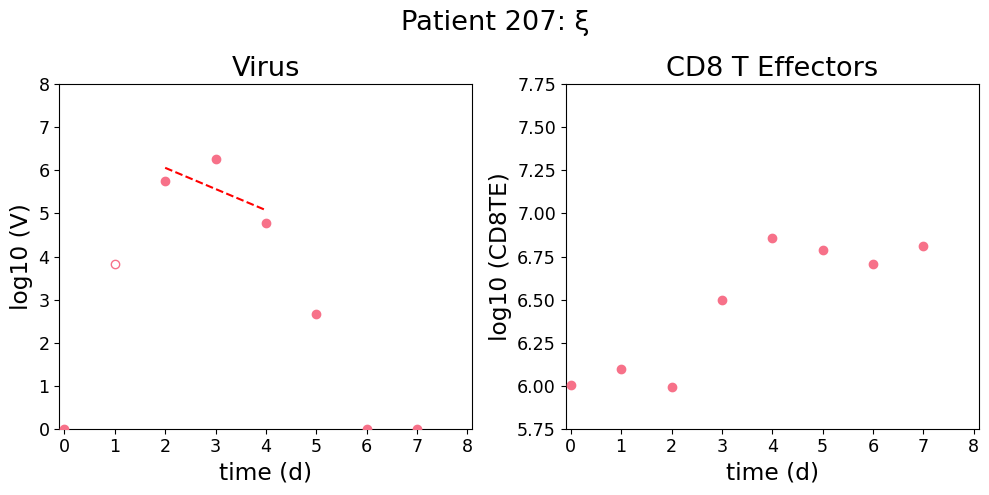

In [15]:
states = [
    {'label': 'T', 'initial_value': 4E8, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': True}, #scaled 7.95E7
    {'label': 'CD8TLung', 'initial_value': 0.0, 'sse': False},
    #{'label': 'IFNY', 'initial_value': 0.0, 'sse': False},
    {'label': 'Z1', 'initial_value': 0.0, 'sse': False},
    {'label': 'Z2', 'initial_value': 0.0, 'sse': False},
    {'label': 'Z3', 'initial_value': 0.0, 'sse': False},
]

ids = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312] #Shedders
ids = [207]
t_span = (0.0, 8.0)
df = pd.read_excel("../Data/References/Elective/Rahil_2020/Table8_Healed.xlsx", usecols=list(range(0, 143)))
df = df[['VOLUNTEER', 'DAY', 'V', 'IFNY', 'CD8TE']]
df = df.loc[df['DAY'] < 9]
df_Rahil = df[df['VOLUNTEER'].isin(ids)]
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 0, '2nd_sol_key': None, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Infected Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 2, '2nd_sol_key': None, 'data_scale': None, 'ylims': [1, 5E8]},
    {'title': 'Virus', 'data_key': 'V', '2nd_data_key': None, 'sol_key': 3, '2nd_sol_key': None, 'data_scale': None, 'ylims': [0,8]},
    {'title': 'CD8 T Effectors', 'data_key': 'CD8TE', '2nd_data_key': 'CD8TE', 'sol_key': 4, '2nd_sol_key': None, 'data_scale': None, 'ylims': [5.75,7.75]}, #[3E4,3E7]
    #{'title': 'CD8T Lung Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 5, '2nd_sol_key': None, 'data_scale': None, 'ylims': None},
]

parameters = Parameters(
    E0=Parameter(name='E0', val=3.47E5, l_lim=1E4, u_lim=1E6, method='file', space='log10'), # MP 3.47E5
    T0=Parameter(name='T0', val=4E8, l_lim=1E8, u_lim=1E10, method='fixed', space='log10'), # MP 4E8
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), # MP 75
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-9, u_lim=1E-1, method='file', space='log10'), # MP 1.0888E-4
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), # MP 4
    p=Parameter(name='p', val=0.02978, l_lim=1E-3, u_lim=100, method='file', space='log10'), # MP 0.02978
    c=Parameter(name='c', val=13.934, l_lim=0.1, u_lim=1000, method='file', space='log10'), # MP 13.934
    delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=2.5, method='file', space='log10'), # MP 0.96
    xi=Parameter(name='xi', val=0.1198, l_lim=1E-2, u_lim=1, method='fit', space='log10'), # MP 0.1198
    a=Parameter(name='a', val=0.3615, l_lim=1E-2, u_lim=1, method='fixed', space='log10'), # MP 0.3615
    tau=Parameter(name='tau', val=1.38, l_lim=1E-1, u_lim=1E1, method='fixed', space='log10'), # MP 1.38
    d_E=Parameter(name='d_E', val=1.25, l_lim=1E-1, u_lim=10, method='fixed', space='log10'), # MP 1.25
    delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-1, u_lim=1E2, method='fixed', space='log10'), # MP 8.939
    K_delta_E=Parameter(name='K_delta_E', val=13019, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'), # MP 13019
)

title=None
method='halton'
patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
results = patients.optimize_parameters(method=method, verbose=True)

for result, patient in results:
    print(f"Results for Patient {patient.id}:")
    print(result)
    if method=='differential_evolution' and result is not None:
        print(np.std(result.population_energies))
        print(np.mean(result.population_energies))
    # Only print parameters that were actually fit
    fit_parameters = {name: param for name, param in patient.parameters._parameters.items() if param.method == 'fit'}
    for param_name, param in fit_parameters.items():
        print(f"Parameter {param_name} optimized to {param.val}")

    for idx, state in enumerate(patient.states):
        state_label = state['label']
        if state.get('sse', True) or state_label in ['CD8TE', 'V']:
            print(patient.sse_statewise)

plot(results, subplot_configuration, title=title,group=False, save=True)

In [20]:
# List parameters to fit
last_6_parameters = ['xi', 'a', 'tau', 'd_E', 'delta_E', 'K_delta_E']
def run_combinations(dim, method='halton', verbose=True):
    # Generate combinations of last 6 parameters for the specified dimension
    combs = list(itertools.combinations(last_6_parameters, dim))

    for comb in combs:
        print(f"\nRunning optimization for combination: {comb}")
        parameters = Parameters(
            E0=Parameter(name='E0', val=3.47E5, l_lim=1E4, u_lim=1E6, method='file', space='log10'), # MP 3.47E5
            T0=Parameter(name='T0', val=4E8, l_lim=1E8, u_lim=1E10, method='fixed', space='log10'), # MP 4E8
            I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), # MP 75
            beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-9, u_lim=1E-1, method='file', space='log10'), # MP 1.0888E-4
            k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), # MP 4
            p=Parameter(name='p', val=0.02978, l_lim=1E-3, u_lim=100, method='file', space='log10'), # MP 0.02978
            c=Parameter(name='c', val=13.934, l_lim=0.1, u_lim=1000, method='file', space='log10'), # MP 13.934
            delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=2.5, method='file', space='log10'), # MP 0.96
            xi=Parameter(name='xi', val=0.1198, l_lim=1E-2, u_lim=1, method='fixed', space='log10'), # MP 0.1198
            a=Parameter(name='a', val=0.3615, l_lim=1E-2, u_lim=1, method='fixed', space='log10'), # MP 0.3615
            tau=Parameter(name='tau', val=1.38, l_lim=1E-1, u_lim=1E1, method='fixed', space='log10'), # MP 1.38
            d_E=Parameter(name='d_E', val=1.25, l_lim=1E-1, u_lim=10, method='fixed', space='log10'), # MP 1.25
            delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-1, u_lim=1E2, method='fixed', space='log10'), # MP 8.939
            K_delta_E=Parameter(name='K_delta_E', val=13019, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'), # MP 13019
        )

        # Set all parameters to fixed
        for param_name in last_6_parameters:
            parameters._parameters[param_name].method = 'fixed'

        # Set only the parameters in the current combination to 'fit'
        for param_name in comb:
            parameters._parameters[param_name].method = 'fit'

        # Initialize and run the optimization for the current combination
        patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
        results = patients.optimize_parameters(method=method, verbose=verbose)

        # Display the results
        for result, patient in results:
            print(f"\nResults for Patient {patient.id}:")
            print(result)
            # Only print parameters that were actually fit
            fit_parameters = {name: param for name, param in patient.parameters._parameters.items() if param.method == 'fit'}
            for param_name, param in fit_parameters.items():
                print(f"Parameter {param_name} optimized to {param.val}")

            # Print SSE results
            for idx, state in enumerate(patient.states):
                state_label = state['label']
                if state.get('sse', True) or state_label in ['CD8TE', 'V']:
                    print(f"{state_label}: {patient.sse_statewise[idx]:.3f}")
            print(f"Slope Penalty: {patient.sse_statewise[-1]:.8f}")
            print(f"Total SSE: {patient.sse:.3f}")
            print()
        
        plot(results, subplot_configuration, title=f'Optimization for {comb}', group=False, save=True)

run_combinations(6, method='halton', verbose=True)


Running optimization for combination: ('xi', 'a', 'tau', 'd_E', 'delta_E', 'K_delta_E')


C:\Users\jorda\AppData\Local\Temp\ipykernel_17876\3210396174.py:64: RuntimeWarning: overflow encountered in scalar power
  return 10 ** value


Database 207pmap:
Rows before deduplication: 50
Rows after deduplication: 50
Total rows: 50
After parameter bounding: 50
Error Summary - sse: min=119.66955526219233, max=119.66955526219996, mean=119.669555262199, std=2.297534127988188e-12
After error filter: 50


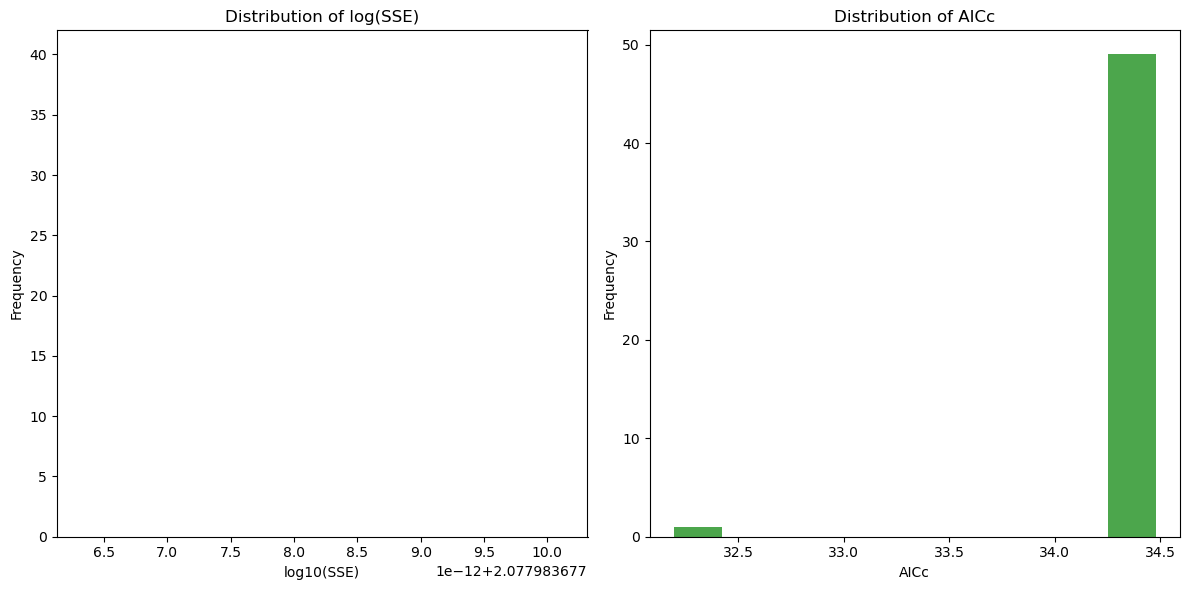

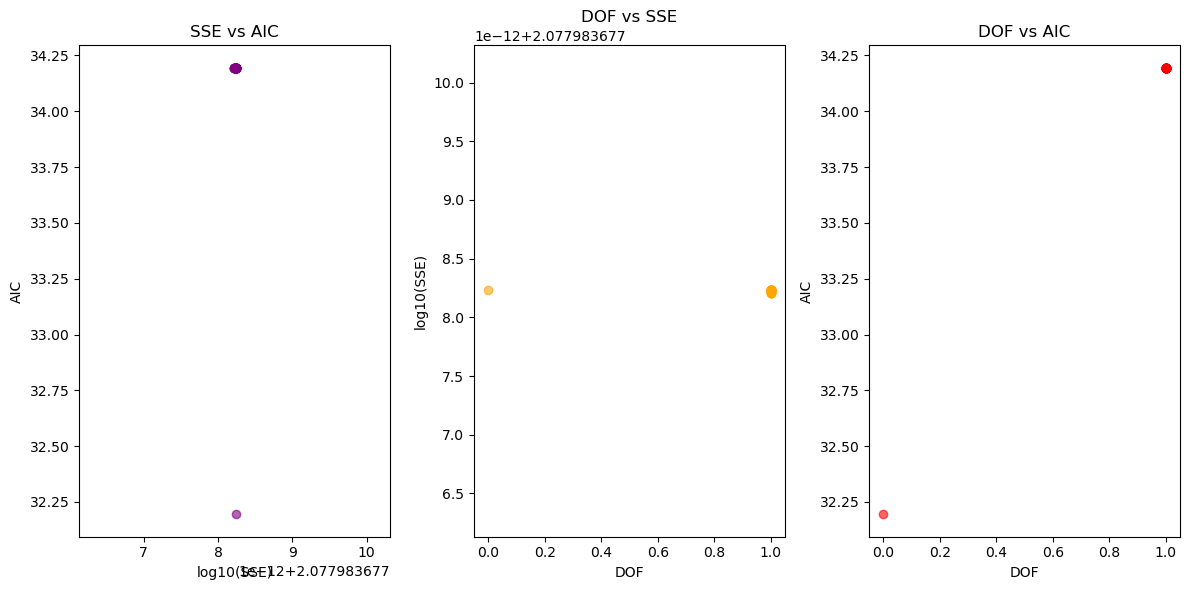

    xi  a  tau  d_E  delta_E  K_delta_E
0    1  0    0    0        0          0
30   1  0    0    0        0          0
20   1  0    0    0        0          0
40   1  0    0    0        0          0
10   1  0    0    0        0          0
21   1  0    0    0        0          0
41   1  0    0    0        0          0
11   1  0    0    0        0          0
1    1  0    0    0        0          0
31   1  0    0    0        0          0
    xi  a  tau  d_E  delta_E  K_delta_E
17   0  0    0    0        0          0
0    1  0    0    0        0          0
30   1  0    0    0        0          0
40   1  0    0    0        0          0
10   1  0    0    0        0          0
20   1  0    0    0        0          0
41   1  0    0    0        0          0
21   1  0    0    0        0          0
11   1  0    0    0        0          0
31   1  0    0    0        0          0
           SSE Correlation  AICc Correlation
xi                0.091877          0.207051
a                      NaN    

C:\Users\jorda\AppData\Local\Temp\ipykernel_19000\1515864824.py:260: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_sse, _ = spearmanr(df[col], df['sse'])
C:\Users\jorda\AppData\Local\Temp\ipykernel_19000\1515864824.py:261: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_aicc, _ = spearmanr(df[col], df['AICc'])


In [16]:
# Databse analysis
def apply_config_log_and_bounds(df, config):
    for param, options in config.items():
        if isinstance(options, dict):  # Only process if 'options' is a dictionary
            if 'log' in options and options['log']:
                df[param] = np.log10(df[param].replace(0, np.nan))
            if options['bounds']:
                lower, upper = options['bounds']
                if lower is not None:
                    df = df[df[param] >= lower]
                if upper is not None:
                    df = df[df[param] <= upper]
    return df

def filter_by_error(df, error_column, threshold=None, log_error=False):
    error = np.log(df[error_column]) if log_error else df[error_column]
    print(f"Error Summary - {error_column}: min={error.min()}, max={error.max()}, mean={error.mean()}, std={error.std()}")
    
    if threshold:
        df = df[error < threshold]
    return df

# Plotting functions
def get_subplot_grid(n_plots):
    if n_plots == 1:
        return (1, 1)
    elif n_plots == 2:
        return (1, 2)
    elif n_plots == 3:
        return (1, 3)
    elif n_plots == 4:
        return (2, 2)
    elif n_plots == 5 or n_plots == 6:
        return (3, 2)
    elif n_plots == 7 or n_plots == 8:
        return (4, 2)
    elif n_plots == 9:
        return (3, 3)
    elif n_plots == 10 or n_plots == 11:
        return (4, 3)
    else:
        return (4, 3)  # Maximum case (12)

def flex_plot(x_data, y_data, titles, x_labels, y_labels):
    n_plots = len(x_data)
    max_plots_per_figure = 12
    
    for start_idx in range(0, n_plots, max_plots_per_figure):
        end_idx = min(start_idx + max_plots_per_figure, n_plots)
        n_plots_in_figure = end_idx - start_idx
        nrows, ncols = get_subplot_grid(n_plots_in_figure)
        
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))
        axs = axs.flatten()
        
        for i in range(n_plots_in_figure):
            axs[i].scatter(x_data[start_idx + i], y_data[start_idx + i], alpha=0.7)
            axs[i].set_title(titles[start_idx + i])
            axs[i].set_xlabel(x_labels[start_idx + i])
            axs[i].set_ylabel(y_labels[start_idx + i])

        for j in range(n_plots_in_figure, len(axs)):
            axs[j].axis('off')

        plt.tight_layout()
        plt.show()

# Plotting histograms of the parameters
def flex_plot_histograms(parameters, df):
    # Find meaningful parameters with more than 1 unique value
    meaningful_params = [param for param in parameters if df[param].nunique() > 1]
    n_plots = len(meaningful_params)
    nrows, ncols = get_subplot_grid(n_plots)

    # Set up figure and axes
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))
    axs = axs.flatten()

    for idx, param in enumerate(meaningful_params):
        # Get the histogram data
        counts, bins, _ = axs[idx].hist(df[param].replace([np.inf, -np.inf], np.nan).dropna(), bins=30, color='b', alpha=0.7)
        
        axs[idx].set_title(f'{param} Distribution')
        axs[idx].set_xlabel('Value')
        axs[idx].set_ylabel('Frequency')
        
        # Find the tallest and second tallest bins
        sorted_counts = sorted(counts, reverse=True)
        tallest_bin = sorted_counts[0]
        second_tallest_bin = sorted_counts[1] if len(sorted_counts) > 1 else tallest_bin

        # Adjust ylim to just above the second tallest bin
        axs[idx].set_ylim([0, second_tallest_bin * 1.2])

        # Find the center of the tallest bin
        tallest_bin_idx = np.argmax(counts)
        tallest_bin_center = (bins[tallest_bin_idx] + bins[tallest_bin_idx + 1]) / 2
        
        # Add a dashed red line at the center of the tallest bin
        axs[idx].axvline(tallest_bin_center, color='red', linestyle='--', ymax=1, alpha=0.8)
        axs[idx].text(tallest_bin_center, second_tallest_bin * 1.1, 'Clipped', color='red', ha='center')

    # Turn off unused axes
    for j in range(len(meaningful_params), len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# Plotting Error vs Parameters
def plot_error_vs_parameters(error_column, log=False):
    meaningful_params = [param for param in parameter_columns if df[param].nunique() > 1]
    x_data, y_data, titles, x_labels, y_labels = [], [], [], [], []
    
    for param in meaningful_params:
        x_data.append(df[param])
        y_data.append(np.log(df[error_column]) if log else df[error_column])
        titles.append(f'{error_column} vs {param}')
        x_labels.append(param)
        y_labels.append(f'log({error_column})' if log else error_column)

    flex_plot(x_data, y_data, titles, x_labels, y_labels)

# 2D Parameter vs Parameter colored by Error
def flex_plot_colored_by_error(x_data, y_data, error_data, titles, x_labels, y_labels, error_label):
    n_plots = len(x_data)
    max_plots_per_figure = 12
    
    for start_idx in range(0, n_plots, max_plots_per_figure):
        end_idx = min(start_idx + max_plots_per_figure, n_plots)
        n_plots_in_figure = end_idx - start_idx
        nrows, ncols = get_subplot_grid(n_plots_in_figure)
        
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))
        axs = axs.flatten()
        
        for i in range(n_plots_in_figure):
            scatter = axs[i].scatter(x_data[i], y_data[i], c=error_data[i], cmap='viridis', alpha=0.7, norm=colors.Normalize(vmin=min(error_data[i]), vmax=max(error_data[i])))
            axs[i].set_title(titles[i])
            axs[i].set_xlabel(x_labels[i])
            axs[i].set_ylabel(y_labels[i])
            fig.colorbar(scatter, ax=axs[i], label=error_label)

        for j in range(n_plots_in_figure, len(axs)):
            axs[j].axis('off')

        plt.tight_layout()
        plt.show()

db_ids = ['207pmap']
df_list = []
parameter_columns = ['E0', 'T0', 'I10', 'beta', 'k', 'p', 'c', 'delta', 'xi', 'a', 'tau', 'd_E', 'delta_E', 'K_delta_E']
for db_id in db_ids:
    db_path = f'sql/{db_id}.db'
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query("SELECT * FROM evaluations", conn)
    
    # Deduplicate rows based on parameter columns
    df_deduplicated = df.drop_duplicates(subset=parameter_columns)
    print(f"Database {db_id}:")
    print(f"Rows before deduplication: {len(df)}")
    print(f"Rows after deduplication: {len(df_deduplicated)}")
    df_deduplicated.to_sql('evaluations', conn, if_exists='replace', index=False)
    df_list.append(df_deduplicated)
    conn.close()

df = pd.concat(df_list, ignore_index=True)
print(f'Total rows: {len(df)}')

config = {
    'xi': {'log': True, 'bounds': [None, None]},
    'a': {'log': True, 'bounds': [None, None]},
    'tau': {'log': True, 'bounds': [None, None]},
    'd_E': {'log': True, 'bounds': [None, None]},
    'delta_E': {'log': True, 'bounds': [None, None]},
    'K_delta_E': {'log': True, 'bounds': [None, None]},
    'error_column': 'sse',
    'log_error': False,  # Take natural log of error or not
    'error_threshold': None  # Filter data to rows where error < threshold
}

df = apply_config_log_and_bounds(df, config)
print(f'After parameter bounding: {len(df)}')
df = filter_by_error(df, config['error_column'], config['error_threshold'], config['log_error'])
print(f'After error filter: {len(df)}')

fit_cols = ['xi', 'a', 'tau', 'd_E', 'delta_E', 'K_delta_E']
mode_values = 10**df[fit_cols].mode().iloc[0]

def calculate_dof(row, mode_values):
    # Compare each row to the mode values and count the differences
    return (10**row[fit_cols] != mode_values.values).sum()

# Calculate DOF
df['DOF'] = df.apply(calculate_dof, mode_values=mode_values, axis=1)

# AIC and AICc calculations
n = 16
df['AIC'] = n * np.log(df['sse'] / n) + 2 * df['DOF']
df['AICc'] = df['AIC'] + (2 * df['DOF'] * (df['DOF'] + 1)) / (n - df['DOF'] - 1)

# Distribution of SSE and AICc
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(np.log10(df['sse']), bins=10, color='blue', alpha=0.7)
plt.title('Distribution of log(SSE)')
plt.xlabel('log10(SSE)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['AICc'], bins=10, color='green', alpha=0.7)
plt.title('Distribution of AICc')
plt.xlabel('AICc')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# SSE, AIC, DOF scatter plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.scatter(np.log10(df['sse']), df['AIC'], color='purple', alpha=0.6)
plt.title('SSE vs AIC')
plt.xlabel('log10(SSE)')
plt.ylabel('AIC')

plt.subplot(1, 3, 2)
plt.scatter(df['DOF'], np.log10(df['sse']), color='orange', alpha=0.6)
plt.title('DOF vs SSE')
plt.xlabel('DOF')
plt.ylabel('log10(SSE)')

plt.subplot(1, 3, 3)
plt.scatter(df['DOF'], df['AIC'], color='red', alpha=0.6)
plt.title('DOF vs AIC')
plt.xlabel('DOF')
plt.ylabel('AIC')

plt.tight_layout()
plt.show()

# Sorting by SSE and AICc
best_by_sse = df.sort_values(by='sse').head(10)
best_by_aicc = df.sort_values(by='AICc').head(10)

# Identifying differences from mode for best rows
best_by_sse_diff = 10**best_by_sse[fit_cols] != mode_values.values
best_by_aicc_diff = 10**best_by_aicc[fit_cols] != mode_values.values

# Convert boolean to 1/0 for display
best_by_sse_diff_display = best_by_sse_diff.astype(int)
best_by_aicc_diff_display = best_by_aicc_diff.astype(int)

print(best_by_sse_diff_display)
print(best_by_aicc_diff_display)

# Perform Spearman correlation for each parameter against SSE and AICc
correlation_results = {}
for col in fit_cols:
    corr_sse, _ = spearmanr(df[col], df['sse'])
    corr_aicc, _ = spearmanr(df[col], df['AICc'])
    correlation_results[col] = {'SSE Correlation': corr_sse, 'AICc Correlation': corr_aicc}

# Convert correlation results to a DataFrame for display
corr_df = pd.DataFrame(correlation_results).T
print(corr_df)

AttributeError: 'Axes' object has no attribute 'flatten'

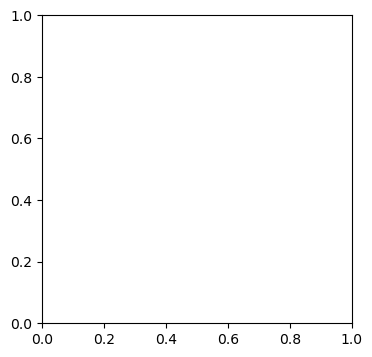

In [12]:
# Histograms
parameter_columns = ['xi', 'a', 'tau', 'd_E', 'delta_E', 'K_delta_E']
flex_plot_histograms(parameter_columns, df)
# Error vs Parameters
plot_error_vs_parameters(config['error_column'], log=config['log_error'])

# 2D Scatter plot colored by error
param_pairs = list(combinations(parameter_columns, 2))
x_data, y_data, error_data, titles, x_labels, y_labels = [], [], [], [], [], []
for param1, param2 in param_pairs:
    x_data.append(df[param1])
    y_data.append(df[param2])
    error_data.append(df[config['error_column']])
    titles.append(f'{param1} vs {param2}')
    x_labels.append(param1)
    y_labels.append(param2)
flex_plot_colored_by_error(x_data, y_data, error_data, titles, x_labels, y_labels, config['error_column'])

(1, 9)


IndexError: list index out of range

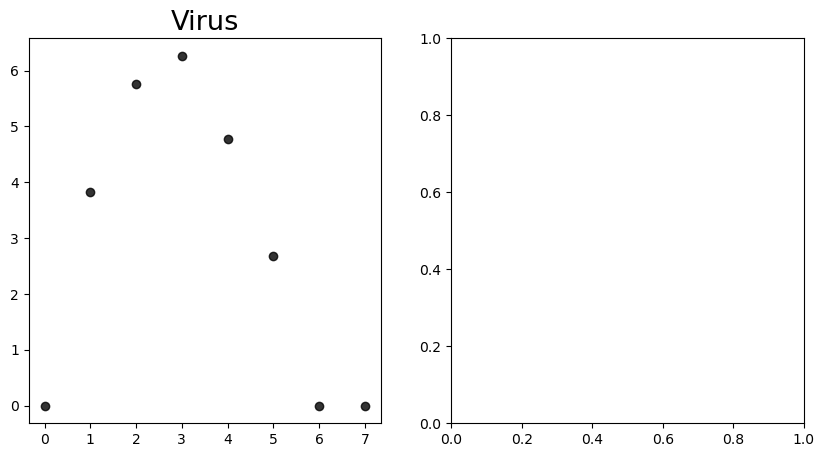

In [27]:
def run_julia_solve_for_best_solutions(best_solutions, t_span, error_column):
    """
    Run Julia ODE solver for the best solutions obtained from the database.
    """
    results = []
    
    for index, row in best_solutions.iterrows():
        # Extract the parameter set from the row
        params = {
            "E0": row['E0'],
            "beta": row['beta'],
            "k": row['k'],
            "delta": row['delta'],
            "delta_E": row['delta_E'],
            "K_delta_E": row['K_delta_E'],
            "p": row['p'],
            "c": row['c'],
            "xi": row['xi'],
            "tau": row['tau'],
            "a": row['a'],
            "d_E": row['d_E']
        }
        # Initial conditions for all states
        y0 = [
            row['T0'],       # T
            row['I10'],      # I1
            0.0,             # I2 (infected cells)
            0.0,       # V (virus)
            0.0,             # CD8TE
            0.0,             # CD8TLung
            0.0,             # Z1
            0.0,             # Z2
            0.0              # Z3
        ]
        
        # Solve using Julia
        solt, soly = solve_with_julia(t_span, y0, params)
        
        # Store the solution for plotting, include the error metric from `row`
        results.append({
            'index': index,  # Can be used to plot results
            'sol': soly,
            't':solt,
            'params': params,
            error_column: row[error_column]  # Include the error metric for coloring
        })

    return results

def julia_plot(results, subplot_config, df=None, error_column='sse'):
    """
    Plot the results for each solution. The traces are colored based on the error metric.

    Parameters:
    - results: A list of solutions from multiple runs (with parameter sets and their errors).
    - subplot_config: Configuration for subplots with titles and keys for data and solutions.
    - error_column: The column/attribute in the result to use for coloring the traces based on the error.
    """
    t_span = [0, 8]
    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 1)
    n_subplots = len(subplot_config)
    
    # Determine the number of rows and columns based on the number of subplots
    if n_subplots <= 3:
        n_rows, n_cols = 1, n_subplots
    else:
        n_rows, n_cols = int(np.ceil(np.sqrt(n_subplots))), int(np.ceil(n_subplots / np.sqrt(n_subplots)))

    # Set up figure and subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5), squeeze=False)
    axs_flat = axs.flatten()

    # Define base font sizes for various plot elements
    base_font_size = 14
    title_font_size = base_font_size * 1.4
    label_font_size = base_font_size * 1.2
    tick_font_size = base_font_size * 0.9

    # Extract error metrics from results
    errors = [result[error_column] for result in results]
    norm = colors.Normalize(vmin=np.min(errors), vmax=np.max(errors))  # Normalize errors for coloring

    for i, config in enumerate(subplot_config):
        ax = axs_flat[i]
        ax.set_title(config['title'], fontsize=title_font_size)
        # If data is present for the subplot, plot the data points (based on data_key)
        if config['data_key'] and df is not None:
            volunteer_data = df[['DAY', config['data_key']]]  # Assuming each result has corresponding data
            if config['data_scale'] is not None:
                volunteer_data[config['data_key']] *= config['data_scale']
            
            ax.plot(volunteer_data['DAY'], np.log10(np.maximum(volunteer_data[config['data_key']], 1.0)),
                    marker='o', color='black', linestyle='None', alpha=0.8, zorder=15)
            
        for result in results:
            # Get the solution and parameters
            sol_t = result['t']
            print(np.shape(result['sol']))
            sol_y_raw = result['sol'][config['sol_key']]
            if config['data_key'] == 'CD8TE':
                sol_y_raw += result['params']['E0']
            sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))  # Apply log10 to the solution

            # Color the trace based on the error
            error_value = result[error_column]
            color = plt.cm.viridis(norm(error_value))

            ax.plot(sol_t, sol_y, color=color, alpha=0.7)

        # Set axis limits, labels, and ticks
        if config['ylims']:
            ax.set_ylim(config['ylims'])
        ax.set_xticks(x_ticks)
        ax.set_xlim([t_span[0] - 0.1, t_span[-1] + 0.1])
        ax.set_xlabel('time (d)', fontsize=label_font_size)
        ax.set_ylabel(f'log10({config["data_key"]})', fontsize=label_font_size)
        ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

    # Remove unused subplots
    for j in range(i + 1, len(axs_flat)):
        axs_flat[j].set_visible(False)


    # Adjust the subplot layout to make space for the colorbar
    plt.subplots_adjust(bottom=0.1, top=0.9, right=0.85)

    # Add colorbar outside the subplots
    cbar_ax = fig.add_axes([0.88, 0.1, 0.03, 0.8])  # Position for colorbar [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  # Only for the color bar
    fig.colorbar(sm, cax=cbar_ax, label=error_column)

    # Show the plot
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to not overlap with colorbar
    plt.show()
    
t_span = (0.0, 8.0)
log_columns = ['tau', 'd_E', 'delta_E', 'K_delta_E', 'a', 'xi']
df[log_columns] = df[log_columns].apply(lambda col: 10 ** col)
results = run_julia_solve_for_best_solutions(df, t_span, error_column=config['error_column'])


subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 0, '2nd_sol_key': None, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Infected Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 2, '2nd_sol_key': None, 'data_scale': None, 'ylims': [1, 5E8]},
    {'title': 'Virus', 'data_key': 'V', '2nd_data_key': None, 'sol_key': 3, '2nd_sol_key': None, 'data_scale': None, 'ylims': [0,8]},
    {'title': 'CD8 T Effectors', 'data_key': 'CD8TE', '2nd_data_key': 'CD8TE', 'sol_key': 4, '2nd_sol_key': None, 'data_scale': None, 'ylims': [5.75,7.75]}, #[3E4,3E7]
    #{'title': 'CD8T Lung Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 5, '2nd_sol_key': None, 'data_scale': None, 'ylims': None},
]
julia_plot(results, subplot_configuration, df_Rahil, error_column=config['error_column'])